<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week38.do.txt --no_mako -->
<!-- dom:TITLE: Week 38: Statistical analysis, bias-variance tradeoff and resampling methods -->

# Week 38: Statistical analysis, bias-variance tradeoff and resampling methods
**Morten Hjorth-Jensen**, Department of Physics and Center for Computing in Science Education, University of Oslo, Norway

Date: **September 15-19, 2025**

## Plans for week 38, lecture Monday September 15

**Material for the lecture on Monday September 15.**

1. Statistical interpretation of OLS and various expectation values

2. Resampling techniques, Bootstrap and cross validation and bias-variance tradeoff

3. The material we did not cover last week, that is on more advanced methods for updating the learning rate, are covered by its own video. We will briefly discuss these topics at the beginning of the lecture and during the lab sessions. See video on ADAgrad, RMSprop and ADAM (material from last week not covered during lecture) at <https://youtu.be/J_41Hld6tTU>

4. [Video of Lecture](https://youtu.be/4Fo7ITVA7V4)

5. [Whiteboard notes](https://github.com/CompPhysics/MachineLearning/blob/master/doc/HandWrittenNotes/2025/FYSSTKweek38.pdf)

## Readings and Videos
1. Raschka et al, pages 175-192

2. Hastie et al Chapter 7, here we recommend 7.1-7.5 and 7.10 (cross-validation) and 7.11 (bootstrap). See <https://link.springer.com/book/10.1007/978-0-387-84858-7>.

3. [Video on bias-variance tradeoff](https://www.youtube.com/watch?v=EuBBz3bI-aA)

4. [Video on Bootstrapping](https://www.youtube.com/watch?v=Xz0x-8-cgaQ)

5. [Video on cross validation](https://www.youtube.com/watch?v=fSytzGwwBVw)

For the lab session, the following video on cross validation (from 2024), could be helpful, see <https://www.youtube.com/watch?v=T9jjWsmsd1o>

## Linking the regression analysis with a statistical interpretation

We will now couple the discussions of ordinary least squares, Ridge
and Lasso regression with a statistical interpretation, that is we
move from a linear algebra analysis to a statistical analysis. In
particular, we will focus on what the regularization terms can result
in.  We will amongst other things show that the regularization
parameter can reduce considerably the variance of the parameters
$\theta$.

On of the advantages of doing linear regression is that we actually end up with
analytical expressions for several statistical quantities.  
Standard least squares and Ridge regression  allow us to
derive quantities like the variance and other expectation values in a
rather straightforward way.

It is assumed that $\varepsilon_i
\sim \mathcal{N}(0, \sigma^2)$ and the $\varepsilon_{i}$ are
independent, i.e.:

$$
\begin{align*} 
\mbox{Cov}(\varepsilon_{i_1},
\varepsilon_{i_2}) & = \left\{ \begin{array}{lcc} \sigma^2 & \mbox{if}
& i_1 = i_2, \\ 0 & \mbox{if} & i_1 \not= i_2.  \end{array} \right.
\end{align*}
$$

The randomness of $\varepsilon_i$ implies that
$\mathbf{y}_i$ is also a random variable. In particular,
$\mathbf{y}_i$ is normally distributed, because $\varepsilon_i \sim
\mathcal{N}(0, \sigma^2)$ and $\mathbf{X}_{i,\ast} \, \boldsymbol{\theta}$ is a
non-random scalar. To specify the parameters of the distribution of
$\mathbf{y}_i$ we need to calculate its first two moments. 

Recall that $\boldsymbol{X}$ is a matrix of dimensionality $n\times p$. The
notation above $\mathbf{X}_{i,\ast}$ means that we are looking at the
row number $i$ and perform a sum over all values $p$.

## Assumptions made

The assumption we have made here can be summarized as (and this is going to be useful when we discuss the bias-variance trade off)
that there exists a function $f(\boldsymbol{x})$ and  a normal distributed error $\boldsymbol{\varepsilon}\sim \mathcal{N}(0, \sigma^2)$
which describe our data

$$
\boldsymbol{y} = f(\boldsymbol{x})+\boldsymbol{\varepsilon}
$$

We approximate this function with our model from the solution of the linear regression equations, that is our
function $f$ is approximated by $\boldsymbol{\tilde{y}}$ where we want to minimize $(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2$, our MSE, with

$$
\boldsymbol{\tilde{y}} = \boldsymbol{X}\boldsymbol{\theta}.
$$

## Expectation value and variance

We can calculate the expectation value of $\boldsymbol{y}$ for a given element $i$

$$
\begin{align*} 
\mathbb{E}(y_i) & =
\mathbb{E}(\mathbf{X}_{i, \ast} \, \boldsymbol{\theta}) + \mathbb{E}(\varepsilon_i)
\, \, \, = \, \, \, \mathbf{X}_{i, \ast} \, \theta, 
\end{align*}
$$

while
its variance is

$$
\begin{align*} \mbox{Var}(y_i) & = \mathbb{E} \{ [y_i
- \mathbb{E}(y_i)]^2 \} \, \, \, = \, \, \, \mathbb{E} ( y_i^2 ) -
[\mathbb{E}(y_i)]^2  \\  & = \mathbb{E} [ ( \mathbf{X}_{i, \ast} \,
\theta + \varepsilon_i )^2] - ( \mathbf{X}_{i, \ast} \, \boldsymbol{\theta})^2 \\ &
= \mathbb{E} [ ( \mathbf{X}_{i, \ast} \, \boldsymbol{\theta})^2 + 2 \varepsilon_i
\mathbf{X}_{i, \ast} \, \boldsymbol{\theta} + \varepsilon_i^2 ] - ( \mathbf{X}_{i,
\ast} \, \theta)^2 \\  & = ( \mathbf{X}_{i, \ast} \, \boldsymbol{\theta})^2 + 2
\mathbb{E}(\varepsilon_i) \mathbf{X}_{i, \ast} \, \boldsymbol{\theta} +
\mathbb{E}(\varepsilon_i^2 ) - ( \mathbf{X}_{i, \ast} \, \boldsymbol{\theta})^2 
\\ & = \mathbb{E}(\varepsilon_i^2 ) \, \, \, = \, \, \,
\mbox{Var}(\varepsilon_i) \, \, \, = \, \, \, \sigma^2.  
\end{align*}
$$

Hence, $y_i \sim \mathcal{N}( \mathbf{X}_{i, \ast} \, \boldsymbol{\theta}, \sigma^2)$, that is $\boldsymbol{y}$ follows a normal distribution with 
mean value $\boldsymbol{X}\boldsymbol{\theta}$ and variance $\sigma^2$ (not be confused with the singular values of the SVD).

## Expectation value and variance for $\boldsymbol{\theta}$

With the OLS expressions for the optimal parameters $\boldsymbol{\hat{\theta}}$ we can evaluate the expectation value

$$
\mathbb{E}(\boldsymbol{\hat{\theta}}) = \mathbb{E}[ (\mathbf{X}^{\top} \mathbf{X})^{-1}\mathbf{X}^{T} \mathbf{Y}]=(\mathbf{X}^{T} \mathbf{X})^{-1}\mathbf{X}^{T} \mathbb{E}[ \mathbf{Y}]=(\mathbf{X}^{T} \mathbf{X})^{-1} \mathbf{X}^{T}\mathbf{X}\boldsymbol{\theta}=\boldsymbol{\theta}.
$$

This means that the estimator of the regression parameters is unbiased.

We can also calculate the variance

The variance of the optimal value $\boldsymbol{\hat{\theta}}$ is

$$
\begin{eqnarray*}
\mbox{Var}(\boldsymbol{\hat{\theta}}) & = & \mathbb{E} \{ [\boldsymbol{\theta} - \mathbb{E}(\boldsymbol{\theta})] [\boldsymbol{\theta} - \mathbb{E}(\boldsymbol{\theta})]^{T} \}
\\
& = & \mathbb{E} \{ [(\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \mathbf{Y} - \boldsymbol{\theta}] \, [(\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \mathbf{Y} - \boldsymbol{\theta}]^{T} \}
\\
% & = & \mathbb{E} \{ [(\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \mathbf{Y}] \, [(\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \mathbf{Y}]^{T} \} - \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}
% \\
% & = & \mathbb{E} \{ (\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \mathbf{Y} \, \mathbf{Y}^{T} \, \mathbf{X} \, (\mathbf{X}^{T} \mathbf{X})^{-1}  \} - \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}
% \\
& = & (\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \, \mathbb{E} \{ \mathbf{Y} \, \mathbf{Y}^{T} \} \, \mathbf{X} \, (\mathbf{X}^{T} \mathbf{X})^{-1} - \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}
\\
& = & (\mathbf{X}^{T} \mathbf{X})^{-1} \, \mathbf{X}^{T} \, \{ \mathbf{X} \, \boldsymbol{\theta} \, \boldsymbol{\theta}^{T} \,  \mathbf{X}^{T} + \sigma^2 \} \, \mathbf{X} \, (\mathbf{X}^{T} \mathbf{X})^{-1} - \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}
% \\
% & = & (\mathbf{X}^T \mathbf{X})^{-1} \, \mathbf{X}^T \, \mathbf{X} \, \boldsymbol{\theta} \, \boldsymbol{\theta}^T \,  \mathbf{X}^T \, \mathbf{X} \, (\mathbf{X}^T % \mathbf{X})^{-1}
% \\
% & & + \, \, \sigma^2 \, (\mathbf{X}^T \mathbf{X})^{-1} \, \mathbf{X}^T  \, \mathbf{X} \, (\mathbf{X}^T \mathbf{X})^{-1} - \boldsymbol{\theta} \boldsymbol{\theta}^T
\\
& = & \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}  + \sigma^2 \, (\mathbf{X}^{T} \mathbf{X})^{-1} - \boldsymbol{\theta} \, \boldsymbol{\theta}^{T}
\, \, \, = \, \, \, \sigma^2 \, (\mathbf{X}^{T} \mathbf{X})^{-1},
\end{eqnarray*}
$$

where we have used  that $\mathbb{E} (\mathbf{Y} \mathbf{Y}^{T}) =
\mathbf{X} \, \boldsymbol{\theta} \, \boldsymbol{\theta}^{T} \, \mathbf{X}^{T} +
\sigma^2 \, \mathbf{I}_{nn}$. From $\mbox{Var}(\boldsymbol{\theta}) = \sigma^2
\, (\mathbf{X}^{T} \mathbf{X})^{-1}$, one obtains an estimate of the
variance of the estimate of the $j$-th regression coefficient:
$\boldsymbol{\sigma}^2 (\boldsymbol{\theta}_j ) = \boldsymbol{\sigma}^2 [(\mathbf{X}^{T} \mathbf{X})^{-1}]_{jj} $. This may be used to
construct a confidence interval for the estimates.

In a similar way, we can obtain analytical expressions for say the
expectation values of the parameters $\boldsymbol{\theta}$ and their variance
when we employ Ridge regression, allowing us again to define a confidence interval. 

It is rather straightforward to show that

$$
\mathbb{E} \big[ \boldsymbol{\theta}^{\mathrm{Ridge}} \big]=(\mathbf{X}^{T} \mathbf{X} + \lambda \mathbf{I}_{pp})^{-1} (\mathbf{X}^{\top} \mathbf{X})\boldsymbol{\theta}^{\mathrm{OLS}}.
$$

We see clearly that 
$\mathbb{E} \big[ \boldsymbol{\theta}^{\mathrm{Ridge}} \big] \not= \boldsymbol{\theta}^{\mathrm{OLS}}$ for any $\lambda > 0$. We say then that the ridge estimator is biased.

We can also compute the variance as

$$
\mbox{Var}[\boldsymbol{\theta}^{\mathrm{Ridge}}]=\sigma^2[  \mathbf{X}^{T} \mathbf{X} + \lambda \mathbf{I} ]^{-1}  \mathbf{X}^{T} \mathbf{X} \{ [  \mathbf{X}^{\top} \mathbf{X} + \lambda \mathbf{I} ]^{-1}\}^{T},
$$

and it is easy to see that if the parameter $\lambda$ goes to infinity then the variance of Ridge parameters $\boldsymbol{\theta}$ goes to zero. 

With this, we can compute the difference

$$
\mbox{Var}[\boldsymbol{\theta}^{\mathrm{OLS}}]-\mbox{Var}(\boldsymbol{\theta}^{\mathrm{Ridge}})=\sigma^2 [  \mathbf{X}^{T} \mathbf{X} + \lambda \mathbf{I} ]^{-1}[ 2\lambda\mathbf{I} + \lambda^2 (\mathbf{X}^{T} \mathbf{X})^{-1} ] \{ [  \mathbf{X}^{T} \mathbf{X} + \lambda \mathbf{I} ]^{-1}\}^{T}.
$$

The difference is non-negative definite since each component of the
matrix product is non-negative definite. 
This means the variance we obtain with the standard OLS will always for $\lambda > 0$ be larger than the variance of $\boldsymbol{\theta}$ obtained with the Ridge estimator. This has interesting consequences when we discuss the so-called bias-variance trade-off below.

## Deriving OLS from a probability distribution

Our basic assumption when we derived the OLS equations was to assume
that our output is determined by a given continuous function
$f(\boldsymbol{x})$ and a random noise $\boldsymbol{\epsilon}$ given by the normal
distribution with zero mean value and an undetermined variance
$\sigma^2$.

We found above that the outputs $\boldsymbol{y}$ have a mean value given by
$\boldsymbol{X}\hat{\boldsymbol{\theta}}$ and variance $\sigma^2$. Since the entries to
the design matrix are not stochastic variables, we can assume that the
probability distribution of our targets is also a normal distribution
but now with mean value $\boldsymbol{X}\hat{\boldsymbol{\theta}}$. This means that a
single output $y_i$ is given by the Gaussian distribution

$$
y_i\sim \mathcal{N}(\boldsymbol{X}_{i,*}\boldsymbol{\theta}, \sigma^2)=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(y_i-\boldsymbol{X}_{i,*}\boldsymbol{\theta})^2}{2\sigma^2}\right]}.
$$

## Independent and Identically Distributed (iid)

We assume now that the various $y_i$ values are stochastically distributed according to the above Gaussian distribution. 
We define this distribution as

$$
p(y_i, \boldsymbol{X}\vert\boldsymbol{\theta})=\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(y_i-\boldsymbol{X}_{i,*}\boldsymbol{\theta})^2}{2\sigma^2}\right]},
$$

which reads as finding the likelihood of an event $y_i$ with the input variables $\boldsymbol{X}$ given the parameters (to be determined) $\boldsymbol{\theta}$.

Since these events are assumed to be independent and identicall distributed we can build the probability distribution function (PDF) for all possible event $\boldsymbol{y}$ as the product of the single events, that is we have

$$
p(\boldsymbol{y},\boldsymbol{X}\vert\boldsymbol{\theta})=\prod_{i=0}^{n-1}\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(y_i-\boldsymbol{X}_{i,*}\boldsymbol{\theta})^2}{2\sigma^2}\right]}=\prod_{i=0}^{n-1}p(y_i,\boldsymbol{X}\vert\boldsymbol{\theta}).
$$

We will write this in a more compact form reserving $\boldsymbol{D}$ for the domain of events, including the ouputs (targets) and the inputs. That is
in case we have a simple one-dimensional input and output case

$$
\boldsymbol{D}=[(x_0,y_0), (x_1,y_1),\dots, (x_{n-1},y_{n-1})].
$$

In the more general case the various inputs should be replaced by the possible features represented by the input data set $\boldsymbol{X}$. 
We can now rewrite the above probability as

$$
p(\boldsymbol{D}\vert\boldsymbol{\theta})=\prod_{i=0}^{n-1}\frac{1}{\sqrt{2\pi\sigma^2}}\exp{\left[-\frac{(y_i-\boldsymbol{X}_{i,*}\boldsymbol{\theta})^2}{2\sigma^2}\right]}.
$$

It is a conditional probability (see below) and reads as the likelihood of a domain of events $\boldsymbol{D}$ given a set of parameters $\boldsymbol{\theta}$.

## Maximum Likelihood Estimation (MLE)

In statistics, maximum likelihood estimation (MLE) is a method of
estimating the parameters of an assumed probability distribution,
given some observed data. This is achieved by maximizing a likelihood
function so that, under the assumed statistical model, the observed
data is the most probable. 

We will assume here that our events are given by the above Gaussian
distribution and we will determine the optimal parameters $\theta$ by
maximizing the above PDF. However, computing the derivatives of a
product function is cumbersome and can easily lead to overflow and/or
underflowproblems, with potentials for loss of numerical precision.

In practice, it is more convenient to maximize the logarithm of the
PDF because it is a monotonically increasing function of the argument.
Alternatively, and this will be our option, we will minimize the
negative of the logarithm since this is a monotonically decreasing
function.

Note also that maximization/minimization of the logarithm of the PDF
is equivalent to the maximization/minimization of the function itself.

## A new Cost Function

We could now define a new cost function to minimize, namely the negative logarithm of the above PDF

$$
C(\boldsymbol{\theta})=-\log{\prod_{i=0}^{n-1}p(y_i,\boldsymbol{X}\vert\boldsymbol{\theta})}=-\sum_{i=0}^{n-1}\log{p(y_i,\boldsymbol{X}\vert\boldsymbol{\theta})},
$$

which becomes

$$
C(\boldsymbol{\theta})=\frac{n}{2}\log{2\pi\sigma^2}+\frac{\vert\vert (\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta})\vert\vert_2^2}{2\sigma^2}.
$$

Taking the derivative of the *new* cost function with respect to the parameters $\theta$ we recognize our familiar OLS equation, namely

$$
\boldsymbol{X}^T\left(\boldsymbol{y}-\boldsymbol{X}\boldsymbol{\theta}\right) =0,
$$

which leads to the well-known OLS equation for the optimal paramters $\theta$

$$
\hat{\boldsymbol{\theta}}^{\mathrm{OLS}}=\left(\boldsymbol{X}^T\boldsymbol{X}\right)^{-1}\boldsymbol{X}^T\boldsymbol{y}!
$$

Next week we will make  a similar analysis for Ridge and Lasso regression

## Why resampling methods

Before we proceed, we need to rethink what we have been doing. In our
eager to fit the data, we have omitted several important elements in
our regression analysis. In what follows we will
1. look at statistical properties, including a discussion of mean values, variance and the so-called bias-variance tradeoff

2. introduce resampling techniques like cross-validation, bootstrapping and jackknife and more

and discuss how to select a given model (one of the difficult parts in machine learning).

## Resampling methods
Resampling methods are an indispensable tool in modern
statistics. They involve repeatedly drawing samples from a training
set and refitting a model of interest on each sample in order to
obtain additional information about the fitted model. For example, in
order to estimate the variability of a linear regression fit, we can
repeatedly draw different samples from the training data, fit a linear
regression to each new sample, and then examine the extent to which
the resulting fits differ. Such an approach may allow us to obtain
information that would not be available from fitting the model only
once using the original training sample.

Two resampling methods are often used in Machine Learning analyses,
1. The **bootstrap method**

2. and **Cross-Validation**

In addition there are several other methods such as the Jackknife and the Blocking methods. We will discuss in particular
cross-validation and the bootstrap method.

## Resampling approaches can be computationally expensive

Resampling approaches can be computationally expensive, because they
involve fitting the same statistical method multiple times using
different subsets of the training data. However, due to recent
advances in computing power, the computational requirements of
resampling methods generally are not prohibitive. In this chapter, we
discuss two of the most commonly used resampling methods,
cross-validation and the bootstrap. Both methods are important tools
in the practical application of many statistical learning
procedures. For example, cross-validation can be used to estimate the
test error associated with a given statistical learning method in
order to evaluate its performance, or to select the appropriate level
of flexibility. The process of evaluating a model’s performance is
known as model assessment, whereas the process of selecting the proper
level of flexibility for a model is known as model selection. The
bootstrap is widely used.

## Why resampling methods ?
**Statistical analysis.**

* Our simulations can be treated as *computer experiments*. This is particularly the case for Monte Carlo methods which are widely used in statistical analyses.

* The results can be analysed with the same statistical tools as we would use when analysing experimental data.

* As in all experiments, we are looking for expectation values and an estimate of how accurate they are, i.e., possible sources for errors.

## Statistical analysis

* As in other experiments, many numerical  experiments have two classes of errors:

  * Statistical errors

  * Systematical errors

* Statistical errors can be estimated using standard tools from statistics

* Systematical errors are method specific and must be treated differently from case to case.

## Resampling methods

With all these analytical equations for both the OLS and Ridge
regression, we will now outline how to assess a given model. This will
lead to a discussion of the so-called bias-variance tradeoff (see
below) and so-called resampling methods.

One of the quantities we have discussed as a way to measure errors is
the mean-squared error (MSE), mainly used for fitting of continuous
functions. Another choice is the absolute error.

In the discussions below we will focus on the MSE and in particular since we will split the data into test and training data,
we discuss the
1. prediction error or simply the **test error** $\mathrm{Err_{Test}}$, where we have a fixed training set and the test error is the MSE arising from the data reserved for testing. We discuss also the 

2. training error $\mathrm{Err_{Train}}$, which is the average loss over the training data.

As our model becomes more and more complex, more of the training data tends to  used. The training may thence adapt to more complicated structures in the data. This may lead to a decrease in the bias (see below for code example) and a slight increase of the variance for the test error.
For a certain level of complexity the test error will reach minimum, before starting to increase again. The
training error reaches a saturation.

## Resampling methods: Bootstrap
Bootstrapping is a [non-parametric approach](https://en.wikipedia.org/wiki/Nonparametric_statistics) to statistical inference
that substitutes computation for more traditional distributional
assumptions and asymptotic results. Bootstrapping offers a number of
advantages: 
1. The bootstrap is quite general, although there are some cases in which it fails.  

2. Because it does not require distributional assumptions (such as normally distributed errors), the bootstrap can provide more accurate inferences when the data are not well behaved or when the sample size is small.  

3. It is possible to apply the bootstrap to statistics with sampling distributions that are difficult to derive, even asymptotically. 

4. It is relatively simple to apply the bootstrap to complex data-collection plans (such as stratified and clustered samples).

The textbook by [Davison on the Bootstrap Methods and their Applications](https://www.cambridge.org/core/books/bootstrap-methods-and-their-application/ED2FD043579F27952363566DC09CBD6A) provides many more insights and proofs. In this course we will take a more practical approach and use the results and theorems provided in the literature. For those interested in reading more about the bootstrap methods, we recommend the above text and the one by [Efron and Tibshirani](https://www.routledge.com/An-Introduction-to-the-Bootstrap/Efron-Tibshirani/p/book/9780412042317).

Before we proceed however, we need to remind ourselves about a central theorem in statistics, namely the so-called **central limit theorem**.

## The Central Limit Theorem

Suppose we have a PDF $p(x)$ from which we generate  a series $N$
of averages $\mathbb{E}[x_i]$. Each mean value $\mathbb{E}[x_i]$
is viewed as the average of a specific measurement, e.g., throwing 
dice 100 times and then taking the average value, or producing a certain
amount of random numbers. 
For notational ease, we set $\mathbb{E}[x_i]=x_i$ in the discussion
which follows. We do the same for $\mathbb{E}[z]=z$.

If we compute the mean $z$ of $m$ such mean values $x_i$

$$
z=\frac{x_1+x_2+\dots+x_m}{m},
$$

the question we pose is which is the PDF of the new variable $z$.

## Finding the Limit

The probability of obtaining an average value $z$ is the product of the 
probabilities of obtaining arbitrary individual mean values $x_i$,
but with the constraint that the average is $z$. We can express this through
the following expression

$$
\tilde{p}(z)=\int dx_1p(x_1)\int dx_2p(x_2)\dots\int dx_mp(x_m)
    \delta(z-\frac{x_1+x_2+\dots+x_m}{m}),
$$

where the $\delta$-function enbodies the constraint that the mean is $z$.
All measurements that lead to each individual $x_i$ are expected to
be independent, which in turn means that we can express $\tilde{p}$ as the 
product of individual $p(x_i)$.  The independence assumption is important in the derivation of the central limit theorem.

## Rewriting the $\delta$-function

If we use the integral expression for the $\delta$-function

$$
\delta(z-\frac{x_1+x_2+\dots+x_m}{m})=\frac{1}{2\pi}\int_{-\infty}^{\infty}
   dq\exp{\left(iq(z-\frac{x_1+x_2+\dots+x_m}{m})\right)},
$$

and inserting $e^{i\mu q-i\mu q}$ where $\mu$ is the mean value
we arrive at

$$
\tilde{p}(z)=\frac{1}{2\pi}\int_{-\infty}^{\infty}
   dq\exp{\left(iq(z-\mu)\right)}\left[\int_{-\infty}^{\infty}
   dxp(x)\exp{\left(iq(\mu-x)/m\right)}\right]^m,
$$

with the integral over $x$ resulting in

$$
\int_{-\infty}^{\infty}dxp(x)\exp{\left(iq(\mu-x)/m\right)}=
  \int_{-\infty}^{\infty}dxp(x)
   \left[1+\frac{iq(\mu-x)}{m}-\frac{q^2(\mu-x)^2}{2m^2}+\dots\right].
$$

## Identifying Terms

The second term on the rhs disappears since this is just the mean and 
employing the definition of $\sigma^2$ we have

$$
\int_{-\infty}^{\infty}dxp(x)e^{\left(iq(\mu-x)/m\right)}=
  1-\frac{q^2\sigma^2}{2m^2}+\dots,
$$

resulting in

$$
\left[\int_{-\infty}^{\infty}dxp(x)\exp{\left(iq(\mu-x)/m\right)}\right]^m\approx
  \left[1-\frac{q^2\sigma^2}{2m^2}+\dots \right]^m,
$$

and in the limit $m\rightarrow \infty$ we obtain

$$
\tilde{p}(z)=\frac{1}{\sqrt{2\pi}(\sigma/\sqrt{m})}
    \exp{\left(-\frac{(z-\mu)^2}{2(\sigma/\sqrt{m})^2}\right)},
$$

which is the normal distribution with variance
$\sigma^2_m=\sigma^2/m$, where $\sigma$ is the variance of the PDF $p(x)$
and $\mu$ is also the mean of the PDF $p(x)$.

## Wrapping it up

Thus, the central limit theorem states that the PDF $\tilde{p}(z)$ of
the average of $m$ random values corresponding to a PDF $p(x)$ 
is a normal distribution whose mean is the 
mean value of the PDF $p(x)$ and whose variance is the variance
of the PDF $p(x)$ divided by $m$, the number of values used to compute $z$.

The central limit theorem leads to the well-known expression for the
standard deviation, given by

$$
\sigma_m=
\frac{\sigma}{\sqrt{m}}.
$$

The latter is true only if the average value is known exactly. This is obtained in the limit
$m\rightarrow \infty$  only. Because the mean and the variance are measured quantities we obtain 
the familiar expression in statistics (the so-called Bessel correction)

$$
\sigma_m\approx 
\frac{\sigma}{\sqrt{m-1}}.
$$

In many cases however the above estimate for the standard deviation,
in particular if correlations are strong, may be too simplistic. Keep
in mind that we have assumed that the variables $x$ are independent
and identically distributed. This is obviously not always the
case. For example, the random numbers (or better pseudorandom numbers)
we generate in various calculations do always exhibit some
correlations.

The theorem is satisfied by a large class of PDFs. Note however that for a
finite $m$, it is not always possible to find a closed form /analytic expression for
$\tilde{p}(x)$.

## Confidence Intervals

Confidence intervals are used in statistics and represent a type of estimate
computed from the observed data. This gives a range of values for an
unknown parameter such as the parameters $\boldsymbol{\theta}$ from linear regression.

With the OLS expressions for the parameters $\boldsymbol{\theta}$ we found 
$\mathbb{E}(\boldsymbol{\theta}) = \boldsymbol{\theta}$, which means that the estimator of the regression parameters is unbiased.

In the exercises this week we show that the variance of the estimate of the $j$-th regression coefficient is
$\boldsymbol{\sigma}^2 (\boldsymbol{\theta}_j ) = \boldsymbol{\sigma}^2 [(\mathbf{X}^{T} \mathbf{X})^{-1}]_{jj} $.

This quantity can be used to
construct a confidence interval for the estimates.

## Standard Approach based on the Normal Distribution

We will assume that the parameters $\theta$ follow a normal
distribution.  We can then define the confidence interval.  Here we will be using as
shorthands $\mu_{\theta}$ for the above mean value and $\sigma_{\theta}$
for the standard deviation. We have then a confidence interval

$$
\left(\mu_{\theta}\pm \frac{z\sigma_{\theta}}{\sqrt{n}}\right),
$$

where $z$ defines the level of certainty (or confidence). For a normal
distribution typical parameters are $z=2.576$ which corresponds to a
confidence of $99\%$ while $z=1.96$ corresponds to a confidence of
$95\%$.  A confidence level of $95\%$ is commonly used and it is
normally referred to as a *two-sigmas* confidence level, that is we
approximate $z\approx 2$.

For more discussions of confidence intervals (and in particular linked with a discussion of the bootstrap method), see chapter 5 of the textbook by [Davison on the Bootstrap Methods and their Applications](https://www.cambridge.org/core/books/bootstrap-methods-and-their-application/ED2FD043579F27952363566DC09CBD6A)

In this text you will also find an in-depth discussion of the
Bootstrap method, why it works and various theorems related to it.

## Resampling methods: Bootstrap background

Since $\widehat{\theta} = \widehat{\theta}(\boldsymbol{X})$ is a function of random variables,
$\widehat{\theta}$ itself must be a random variable. Thus it has
a pdf, call this function $p(\boldsymbol{t})$. The aim of the bootstrap is to
estimate $p(\boldsymbol{t})$ by the relative frequency of
$\widehat{\theta}$. You can think of this as using a histogram
in the place of $p(\boldsymbol{t})$. If the relative frequency closely
resembles $p(\vec{t})$, then using numerics, it is straight forward to
estimate all the interesting parameters of $p(\boldsymbol{t})$ using point
estimators.

## Resampling methods: More Bootstrap background

In the case that $\widehat{\theta}$ has
more than one component, and the components are independent, we use the
same estimator on each component separately.  If the probability
density function of $X_i$, $p(x)$, had been known, then it would have
been straightforward to do this by: 
1. Drawing lots of numbers from $p(x)$, suppose we call one such set of numbers $(X_1^*, X_2^*, \cdots, X_n^*)$. 

2. Then using these numbers, we could compute a replica of $\widehat{\theta}$ called $\widehat{\theta}^*$. 

By repeated use of the above two points, many
estimates of $\widehat{\theta}$ can  be obtained. The
idea is to use the relative frequency of $\widehat{\theta}^*$
(think of a histogram) as an estimate of $p(\boldsymbol{t})$.

## Resampling methods: Bootstrap approach

But
unless there is enough information available about the process that
generated $X_1,X_2,\cdots,X_n$, $p(x)$ is in general
unknown. Therefore, [Efron in 1979](https://projecteuclid.org/euclid.aos/1176344552)  asked the
question: What if we replace $p(x)$ by the relative frequency
of the observation $X_i$?

If we draw observations in accordance with
the relative frequency of the observations, will we obtain the same
result in some asymptotic sense? The answer is yes.

## Resampling methods: Bootstrap steps

The independent bootstrap works like this: 

1. Draw with replacement $n$ numbers for the observed variables $\boldsymbol{x} = (x_1,x_2,\cdots,x_n)$. 

2. Define a vector $\boldsymbol{x}^*$ containing the values which were drawn from $\boldsymbol{x}$. 

3. Using the vector $\boldsymbol{x}^*$ compute $\widehat{\theta}^*$ by evaluating $\widehat \theta$ under the observations $\boldsymbol{x}^*$. 

4. Repeat this process $k$ times. 

When you are done, you can draw a histogram of the relative frequency
of $\widehat \theta^*$. This is your estimate of the probability
distribution $p(t)$. Using this probability distribution you can
estimate any statistics thereof. In principle you never draw the
histogram of the relative frequency of $\widehat{\theta}^*$. Instead
you use the estimators corresponding to the statistic of interest. For
example, if you are interested in estimating the variance of $\widehat
\theta$, apply the etsimator $\widehat \sigma^2$ to the values
$\widehat \theta^*$.

## Code example for the Bootstrap method

The following code starts with a Gaussian distribution with mean value
$\mu =100$ and variance $\sigma=15$. We use this to generate the data
used in the bootstrap analysis. The bootstrap analysis returns a data
set after a given number of bootstrap operations (as many as we have
data points). This data set consists of estimated mean values for each
bootstrap operation. The histogram generated by the bootstrap method
shows that the distribution for these mean values is also a Gaussian,
centered around the mean value $\mu=100$ but with standard deviation
$\sigma/\sqrt{n}$, where $n$ is the number of bootstrap samples (in
this case the same as the number of original data points). The value
of the standard deviation is what we expect from the central limit
theorem.

In [1]:
%matplotlib inline

import numpy as np
from time import time
from scipy.stats import norm
import matplotlib.pyplot as plt

# Returns mean of bootstrap samples 
# Bootstrap algorithm
def bootstrap(data, datapoints):
    t = np.zeros(datapoints)
    n = len(data)
    # non-parametric bootstrap         
    for i in range(datapoints):
        t[i] = np.mean(data[np.random.randint(0,n,n)])
    # analysis    
    print("Bootstrap Statistics :")
    print("original           bias      std. error")
    print("%8g %8g %14g %15g" % (np.mean(data), np.std(data),np.mean(t),np.std(t)))
    return t

# We set the mean value to 100 and the standard deviation to 15
mu, sigma = 100, 15
datapoints = 10000
# We generate random numbers according to the normal distribution
x = mu + sigma*np.random.randn(datapoints)
# bootstrap returns the data sample                                    
t = bootstrap(x, datapoints)

We see that our new variance and from that the standard deviation, agrees with the central limit theorem.

## Plotting the Histogram

In [2]:
# the histogram of the bootstrapped data (normalized data if density = True)
n, binsboot, patches = plt.hist(t, 50, density=True, facecolor='red', alpha=0.75)
# add a 'best fit' line  
y = norm.pdf(binsboot, np.mean(t), np.std(t))
lt = plt.plot(binsboot, y, 'b', linewidth=1)
plt.xlabel('x')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

## The bias-variance tradeoff

We will discuss the bias-variance tradeoff in the context of
continuous predictions such as regression. However, many of the
intuitions and ideas discussed here also carry over to classification
tasks. Consider a dataset $\mathcal{D}$ consisting of the data
$\mathbf{X}_\mathcal{D}=\{(y_j, \boldsymbol{x}_j), j=0\ldots n-1\}$. 

Let us assume that the true data is generated from a noisy model

$$
\boldsymbol{y}=f(\boldsymbol{x}) + \boldsymbol{\epsilon}
$$

where $\epsilon$ is normally distributed with mean zero and standard deviation $\sigma^2$.

In our derivation of the ordinary least squares method we defined then
an approximation to the function $f$ in terms of the parameters
$\boldsymbol{\theta}$ and the design matrix $\boldsymbol{X}$ which embody our model,
that is $\boldsymbol{\tilde{y}}=\boldsymbol{X}\boldsymbol{\theta}$. 

Thereafter we found the parameters $\boldsymbol{\theta}$ by optimizing the means squared error via the so-called cost function

$$
C(\boldsymbol{X},\boldsymbol{\theta}) =\frac{1}{n}\sum_{i=0}^{n-1}(y_i-\tilde{y}_i)^2=\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right].
$$

We can rewrite this as

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\frac{1}{n}\sum_i(f_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2+\frac{1}{n}\sum_i(\tilde{y}_i-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2+\sigma^2.
$$

The three terms represent the square of the bias of the learning
method, which can be thought of as the error caused by the simplifying
assumptions built into the method. The second term represents the
variance of the chosen model and finally the last terms is variance of
the error $\boldsymbol{\epsilon}$.

To derive this equation, we need to recall that the variance of $\boldsymbol{y}$ and $\boldsymbol{\epsilon}$ are both equal to $\sigma^2$. The mean value of $\boldsymbol{\epsilon}$ is by definition equal to zero. Furthermore, the function $f$ is not a stochastics variable, idem for $\boldsymbol{\tilde{y}}$.
We use a more compact notation in terms of the expectation value

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\mathbb{E}\left[(\boldsymbol{f}+\boldsymbol{\epsilon}-\boldsymbol{\tilde{y}})^2\right],
$$

and adding and subtracting $\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]$ we get

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\mathbb{E}\left[(\boldsymbol{f}+\boldsymbol{\epsilon}-\boldsymbol{\tilde{y}}+\mathbb{E}\left[\boldsymbol{\tilde{y}}\right]-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2\right],
$$

which, using the abovementioned expectation values can be rewritten as

$$
\mathbb{E}\left[(\boldsymbol{y}-\boldsymbol{\tilde{y}})^2\right]=\mathbb{E}\left[(\boldsymbol{y}-\mathbb{E}\left[\boldsymbol{\tilde{y}}\right])^2\right]+\mathrm{Var}\left[\boldsymbol{\tilde{y}}\right]+\sigma^2,
$$

that is the rewriting in terms of the so-called bias, the variance of the model $\boldsymbol{\tilde{y}}$ and the variance of $\boldsymbol{\epsilon}$.

## A way to Read the Bias-Variance Tradeoff

<!-- dom:FIGURE: [figures/BiasVariance.png, width=600 frac=0.9] -->
<!-- begin figure -->

<img src="figures/BiasVariance.png" width="600"><p style="font-size: 0.9em"><i>Figure 1: </i></p>
<!-- end figure -->

## Example code for Bias-Variance tradeoff

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

n = 500
n_boostraps = 100
degree = 18  # A quite high value, just to show.
noise = 0.1

# Make data set.
x = np.linspace(-1, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2) + np.random.normal(0, 0.1, x.shape)

# Hold out some test data that is never used in training.
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# Combine x transformation and model into one operation.
# Not neccesary, but convenient.
model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))

# The following (m x n_bootstraps) matrix holds the column vectors y_pred
# for each bootstrap iteration.
y_pred = np.empty((y_test.shape[0], n_boostraps))
for i in range(n_boostraps):
    x_, y_ = resample(x_train, y_train)

    # Evaluate the new model on the same test data each time.
    y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()

# Note: Expectations and variances taken w.r.t. different training
# data sets, hence the axis=1. Subsequent means are taken across the test data
# set in order to obtain a total value, but before this we have error/bias/variance
# calculated per data point in the test set.
# Note 2: The use of keepdims=True is important in the calculation of bias as this 
# maintains the column vector form. Dropping this yields very unexpected results.
error = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
bias = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
print('Error:', error)
print('Bias^2:', bias)
print('Var:', variance)
print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

plt.plot(x[::5, :], y[::5, :], label='f(x)')
plt.scatter(x_test, y_test, label='Data points')
plt.scatter(x_test, np.mean(y_pred, axis=1), label='Pred')
plt.legend()
plt.show()

## Understanding what happens

Polynomial degree: 0
Error: 0.2937910450030775
Bias^2: 0.2929212799917661
Var: 0.0008697650113114114
0.2937910450030775 >= 0.2929212799917661 + 0.0008697650113114114 = 0.2937910450030775
Polynomial degree: 1
Error: 0.06894146856540673
Bias^2: 0.06832043024896824
Var: 0.0006210383164384981
0.06894146856540673 >= 0.06832043024896824 + 0.0006210383164384981 = 0.06894146856540674
Polynomial degree: 2
Error: 0.06106765054837855
Bias^2: 0.060547654220995305
Var: 0.0005199963273832366
0.06106765054837855 >= 0.060547654220995305 + 0.0005199963273832366 = 0.06106765054837854
Polynomial degree: 3
Error: 0.03346202229536658
Bias^2: 0.033140956468054594
Var: 0.0003210658273119926
0.03346202229536658 >= 0.033140956468054594 + 0.0003210658273119926 = 0.033462022295366586
Polynomial degree: 4
Error: 0.0335277871704832
Bias^2: 0.03311607538577367
Var: 0.0004117117847095275
0.0335277871704832 >= 0.03311607538577367 + 0.0004117117847095275 = 0.0335277871704832
Polynomial degree: 5
Error: 0.0255171515308

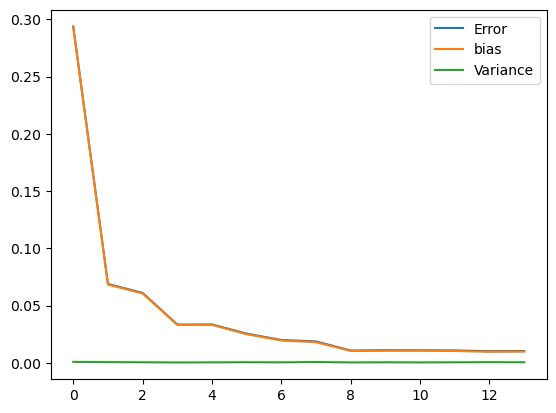

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample

np.random.seed(2018)

n = 400
n_boostraps = 100
maxdegree = 14


# Make data set.
x = np.linspace(-3, 3, n).reshape(-1, 1)
y = np.exp(-x**2) + 1.5 * np.exp(-(x-2)**2)+ np.random.normal(0, 0.1, x.shape)
error = np.zeros(maxdegree)
bias = np.zeros(maxdegree)
variance = np.zeros(maxdegree)
polydegree = np.zeros(maxdegree)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

for degree in range(maxdegree):
    model = make_pipeline(PolynomialFeatures(degree=degree), LinearRegression(fit_intercept=False))
    y_pred = np.empty((y_test.shape[0], n_boostraps))
    for i in range(n_boostraps):
        x_, y_ = resample(x_train, y_train)
        y_pred[:, i] = model.fit(x_, y_).predict(x_test).ravel()

    polydegree[degree] = degree
    error[degree] = np.mean( np.mean((y_test - y_pred)**2, axis=1, keepdims=True) )
    bias[degree] = np.mean( (y_test - np.mean(y_pred, axis=1, keepdims=True))**2 )
    variance[degree] = np.mean( np.var(y_pred, axis=1, keepdims=True) )
    print('Polynomial degree:', degree)
    print('Error:', error[degree])
    print('Bias^2:', bias[degree])
    print('Var:', variance[degree])
    print('{} >= {} + {} = {}'.format(error[degree], bias[degree], variance[degree], bias[degree]+variance[degree]))

plt.plot(polydegree, error, label='Error')
plt.plot(polydegree, bias, label='bias')
plt.plot(polydegree, variance, label='Variance')
plt.legend()
plt.show()

## Summing up

The bias-variance tradeoff summarizes the fundamental tension in
machine learning, particularly supervised learning, between the
complexity of a model and the amount of training data needed to train
it.  Since data is often limited, in practice it is often useful to
use a less-complex model with higher bias, that is  a model whose asymptotic
performance is worse than another model because it is easier to
train and less sensitive to sampling noise arising from having a
finite-sized training dataset (smaller variance). 

The above equations tell us that in
order to minimize the expected test error, we need to select a
statistical learning method that simultaneously achieves low variance
and low bias. Note that variance is inherently a nonnegative quantity,
and squared bias is also nonnegative. Hence, we see that the expected
test MSE can never lie below $Var(\epsilon)$, the irreducible error.

What do we mean by the variance and bias of a statistical learning
method? The variance refers to the amount by which our model would change if we
estimated it using a different training data set. Since the training
data are used to fit the statistical learning method, different
training data sets  will result in a different estimate. But ideally the
estimate for our model should not vary too much between training
sets. However, if a method has high variance  then small changes in
the training data can result in large changes in the model. In general, more
flexible statistical methods have higher variance.

You may also find this recent [article](https://www.pnas.org/content/116/32/15849) of interest.

## Another Example from Scikit-Learn's Repository

This example demonstrates the problems of underfitting and overfitting and
how we can use linear regression with polynomial features to approximate
nonlinear functions. The plot shows the function that we want to approximate,
which is a part of the cosine function. In addition, the samples from the
real function and the approximations of different models are displayed. The
models have polynomial features of different degrees. We can see that a
linear function (polynomial with degree 1) is not sufficient to fit the
training samples. This is called **underfitting**. A polynomial of degree 4
approximates the true function almost perfectly. However, for higher degrees
the model will **overfit** the training data, i.e. it learns the noise of the
training data.
We evaluate quantitatively overfitting and underfitting by using
cross-validation. We calculate the mean squared error (MSE) on the validation
set, the higher, the less likely the model generalizes correctly from the
training data.

In [5]:


#print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

## Various steps in cross-validation

When the repetitive splitting of the data set is done randomly,
samples may accidently end up in a fast majority of the splits in
either training or test set. Such samples may have an unbalanced
influence on either model building or prediction evaluation. To avoid
this $k$-fold cross-validation structures the data splitting. The
samples are divided into $k$ more or less equally sized exhaustive and
mutually exclusive subsets. In turn (at each split) one of these
subsets plays the role of the test set while the union of the
remaining subsets constitutes the training set. Such a splitting
warrants a balanced representation of each sample in both training and
test set over the splits. Still the division into the $k$ subsets
involves a degree of randomness. This may be fully excluded when
choosing $k=n$. This particular case is referred to as leave-one-out
cross-validation (LOOCV).

## Cross-validation in brief

For the various values of $k$

1. shuffle the dataset randomly.

2. Split the dataset into $k$ groups.

3. For each unique group:

a. Decide which group to use as set for test data

b. Take the remaining groups as a training data set

c. Fit a model on the training set and evaluate it on the test set

d. Retain the evaluation score and discard the model

5. Summarize the model using the sample of model evaluation scores

## Code Example for Cross-validation and $k$-fold Cross-validation

The code here uses Ridge regression with cross-validation (CV)  resampling and $k$-fold CV in order to fit a specific polynomial.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures

# A seed just to ensure that the random numbers are the same for every run.
# Useful for eventual debugging.
np.random.seed(3155)

# Generate the data.
nsamples = 100
x = np.random.randn(nsamples)
y = 3*x**2 + np.random.randn(nsamples)

## Cross-validation on Ridge regression using KFold only

# Decide degree on polynomial to fit
poly = PolynomialFeatures(degree = 6)

# Decide which values of lambda to use
nlambdas = 500
lambdas = np.logspace(-3, 5, nlambdas)

# Initialize a KFold instance
k = 5
kfold = KFold(n_splits = k)

# Perform the cross-validation to estimate MSE
scores_KFold = np.zeros((nlambdas, k))

i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)
    j = 0
    for train_inds, test_inds in kfold.split(x):
        xtrain = x[train_inds]
        ytrain = y[train_inds]

        xtest = x[test_inds]
        ytest = y[test_inds]

        Xtrain = poly.fit_transform(xtrain[:, np.newaxis])
        ridge.fit(Xtrain, ytrain[:, np.newaxis])

        Xtest = poly.fit_transform(xtest[:, np.newaxis])
        ypred = ridge.predict(Xtest)

        scores_KFold[i,j] = np.sum((ypred - ytest[:, np.newaxis])**2)/np.size(ypred)

        j += 1
    i += 1


estimated_mse_KFold = np.mean(scores_KFold, axis = 1)

## Cross-validation using cross_val_score from sklearn along with KFold

# kfold is an instance initialized above as:
# kfold = KFold(n_splits = k)

estimated_mse_sklearn = np.zeros(nlambdas)
i = 0
for lmb in lambdas:
    ridge = Ridge(alpha = lmb)

    X = poly.fit_transform(x[:, np.newaxis])
    estimated_mse_folds = cross_val_score(ridge, X, y[:, np.newaxis], scoring='neg_mean_squared_error', cv=kfold)

    # cross_val_score return an array containing the estimated negative mse for every fold.
    # we have to the the mean of every array in order to get an estimate of the mse of the model
    estimated_mse_sklearn[i] = np.mean(-estimated_mse_folds)

    i += 1

## Plot and compare the slightly different ways to perform cross-validation

plt.figure()

plt.plot(np.log10(lambdas), estimated_mse_sklearn, label = 'cross_val_score')
plt.plot(np.log10(lambdas), estimated_mse_KFold, 'r--', label = 'KFold')

plt.xlabel('log10(lambda)')
plt.ylabel('mse')

plt.legend()

plt.show()

## More examples on bootstrap and cross-validation and errors

In [7]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error
# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("EoS.csv"),'r')

# Read the EoS data as  csv file and organize the data into two arrays with density and energies
EoS = pd.read_csv(infile, names=('Density', 'Energy'))
EoS['Energy'] = pd.to_numeric(EoS['Energy'], errors='coerce')
EoS = EoS.dropna()
Energies = EoS['Energy']
Density = EoS['Density']
#  The design matrix now as function of various polytrops

Maxpolydegree = 30
X = np.zeros((len(Density),Maxpolydegree))
X[:,0] = 1.0
testerror = np.zeros(Maxpolydegree)
trainingerror = np.zeros(Maxpolydegree)
polynomial = np.zeros(Maxpolydegree)

trials = 100
for polydegree in range(1, Maxpolydegree):
    polynomial[polydegree] = polydegree
    for degree in range(polydegree):
        X[:,degree] = Density**(degree/3.0)

# loop over trials in order to estimate the expectation value of the MSE
    testerror[polydegree] = 0.0
    trainingerror[polydegree] = 0.0
    for samples in range(trials):
        x_train, x_test, y_train, y_test = train_test_split(X, Energies, test_size=0.2)
        model = LinearRegression(fit_intercept=False).fit(x_train, y_train)
        ypred = model.predict(x_train)
        ytilde = model.predict(x_test)
        testerror[polydegree] += mean_squared_error(y_test, ytilde)
        trainingerror[polydegree] += mean_squared_error(y_train, ypred) 

    testerror[polydegree] /= trials
    trainingerror[polydegree] /= trials
    print("Degree of polynomial: %3d"% polynomial[polydegree])
    print("Mean squared error on training data: %.8f" % trainingerror[polydegree])
    print("Mean squared error on test data: %.8f" % testerror[polydegree])

plt.plot(polynomial, np.log10(trainingerror), label='Training Error')
plt.plot(polynomial, np.log10(testerror), label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

Note that we kept the intercept column in the fitting here. This means that we need to set the **intercept** in the call to the **Scikit-Learn** function as **False**. Alternatively, we could have set up the design matrix $X$ without the first column of ones.

## The same example but now with cross-validation

In this example we keep the intercept column again but add cross-validation in order to estimate the best possible value of the means squared error.

In [8]:
# Common imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


# Where to save the figures and data files
PROJECT_ROOT_DIR = "Results"
FIGURE_ID = "Results/FigureFiles"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", format='png')

infile = open(data_path("EoS.csv"),'r')

# Read the EoS data as  csv file and organize the data into two arrays with density and energies
EoS = pd.read_csv(infile, names=('Density', 'Energy'))
EoS['Energy'] = pd.to_numeric(EoS['Energy'], errors='coerce')
EoS = EoS.dropna()
Energies = EoS['Energy']
Density = EoS['Density']
#  The design matrix now as function of various polytrops

Maxpolydegree = 30
X = np.zeros((len(Density),Maxpolydegree))
X[:,0] = 1.0
estimated_mse_sklearn = np.zeros(Maxpolydegree)
polynomial = np.zeros(Maxpolydegree)
k =5
kfold = KFold(n_splits = k)

for polydegree in range(1, Maxpolydegree):
    polynomial[polydegree] = polydegree
    for degree in range(polydegree):
        X[:,degree] = Density**(degree/3.0)
        OLS = LinearRegression(fit_intercept=False)
# loop over trials in order to estimate the expectation value of the MSE
    estimated_mse_folds = cross_val_score(OLS, X, Energies, scoring='neg_mean_squared_error', cv=kfold)
#[:, np.newaxis]
    estimated_mse_sklearn[polydegree] = np.mean(-estimated_mse_folds)

plt.plot(polynomial, np.log10(estimated_mse_sklearn), label='Test Error')
plt.xlabel('Polynomial degree')
plt.ylabel('log10[MSE]')
plt.legend()
plt.show()

## Material for the lab sessions

This week we will discuss during the first hour of each lab session
some technicalities related to the project and methods for updating
the learning like ADAgrad, RMSprop and ADAM. As teaching material, see
the jupyter-notebook from week 37 (September 12-16).

For the lab session, the following video on cross validation (from 2024), could be helpful, see <https://www.youtube.com/watch?v=T9jjWsmsd1o>

See also video on ADAgrad, RMSprop and ADAM (material from last week not covered during lecture) at <https://youtu.be/J_41Hld6tTU>